In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

#Preprocessing
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline



#Model Selection
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import train_test_split

#Metrics
from sklearn.metrics import balanced_accuracy_score, accuracy_score, confusion_matrix

# Models
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import  RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC, LinearSVC

#RegressionModels
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor


#Oversample 
from imblearn.over_sampling import RandomOverSampler, SMOTENC



#Pipeline
from sklearn.pipeline import Pipeline


#other
import os
import warnings
warnings.filterwarnings("ignore")

In [4]:

os.chdir(r'C:\Users\danie\OneDrive\Desktop\Fall2023\ELEC478\Competition\neuron-synapse-prediction')
 
#load in training data on each potential synapse
data = pd.read_csv("./train_data.csv")

#load in additional features for each neuron
feature_weights = pd.read_csv("./feature_weights.csv")
morph_embeddings = pd.read_csv("./morph_embeddings.csv")

In [5]:
print("Main Dataframe Size:",data.shape)
print("\nMain Dataframe:")
data.info()

print("\nFeature Weights Size:",feature_weights.shape)
print("\nFeature Weights:")
feature_weights.info(verbose=False)

print("\nMorphological Embeddings Size:",morph_embeddings.shape)
print("\nMorphological Embeddings:")
morph_embeddings.info(verbose=False)

Main Dataframe Size: (185832, 30)

Main Dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185832 entries, 0 to 185831
Data columns (total 30 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   ID                              185832 non-null  int64  
 1   axonal_coor_x                   185832 non-null  int64  
 2   axonal_coor_y                   185832 non-null  int64  
 3   axonal_coor_z                   185832 non-null  int64  
 4   dendritic_coor_x                185832 non-null  int64  
 5   dendritic_coor_y                185832 non-null  int64  
 6   dendritic_coor_z                185832 non-null  int64  
 7   adp_dist                        185832 non-null  float64
 8   post_skeletal_distance_to_soma  185832 non-null  float64
 9   pre_skeletal_distance_to_soma   185832 non-null  float64
 10  pre_oracle                      185832 non-null  float64
 11  pre_test_score             

In [6]:
# join all feature_weight_i columns into a single np.array column
feature_weights["feature_weights"] = (
    feature_weights.filter(regex="feature_weight_")
    .sort_index(axis=1)
    .apply(lambda x: np.array(x), axis=1)
)
# delete the feature_weight_i columns
feature_weights.drop(
    feature_weights.filter(regex="feature_weight_").columns, axis=1, inplace=True
)

# join all morph_embed_i columns into a single np.array column
morph_embeddings["morph_embeddings"] = (
    morph_embeddings.filter(regex="morph_emb_")
    .sort_index(axis=1)
    .apply(lambda x: np.array(x), axis=1)
)
# delete the morph_embed_i columns
morph_embeddings.drop(
    morph_embeddings.filter(regex="morph_emb_").columns, axis=1, inplace=True
)

In [7]:
data = (
    data.merge(
        feature_weights.rename(columns=lambda x: "pre_" + x), 
        how="left", 
        validate="m:1",
        copy=False,
    )
    .merge(
        feature_weights.rename(columns=lambda x: "post_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
    .merge(
        morph_embeddings.rename(columns=lambda x: "pre_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
    .merge(
        morph_embeddings.rename(columns=lambda x: "post_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 185832 entries, 0 to 185831
Data columns (total 34 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   ID                              185832 non-null  int64  
 1   axonal_coor_x                   185832 non-null  int64  
 2   axonal_coor_y                   185832 non-null  int64  
 3   axonal_coor_z                   185832 non-null  int64  
 4   dendritic_coor_x                185832 non-null  int64  
 5   dendritic_coor_y                185832 non-null  int64  
 6   dendritic_coor_z                185832 non-null  int64  
 7   adp_dist                        185832 non-null  float64
 8   post_skeletal_distance_to_soma  185832 non-null  float64
 9   pre_skeletal_distance_to_soma   185832 non-null  float64
 10  pre_oracle                      185832 non-null  float64
 11  pre_test_score                  185832 non-null  float64
 12  pre_rf_x        

In [9]:
#cosine similarity function
def row_feature_similarity(row):
    pre = row["pre_feature_weights"]
    post = row["post_feature_weights"]
    return (pre * post).sum() / (np.linalg.norm(pre) * np.linalg.norm(post))

In [10]:
#cosine similarity function
def row_morph_similarity(row):
    pre = row["pre_morph_embeddings"]
    post = row["post_morph_embeddings"]
    return (pre * post).sum() / (np.linalg.norm(pre) * np.linalg.norm(post))

In [11]:
def feature_engineering(data, me_similarity = True):
    # compute the cosine similarity between the pre- and post- feature weights
    data["fw_similarity"] = data.apply(row_feature_similarity, axis=1)  

    if me_similarity:
        data['me_similarity'] = data.apply(row_morph_similarity, axis=1)  
        

    #Oracle 
    data['oracle_sq'] = data['pre_oracle'] * data['post_oracle']

    #Test Score
    data['test_score_sq'] = data['pre_test_score'] * data['post_test_score']

    # generate projection group as pre->post
    data["projection_group"] = (
        data["pre_brain_area"].astype(str)
        + "_to_"
        + data["post_brain_area"].astype(str)
    )


In [12]:
feature_engineering(data)

In [13]:
data.isna().sum()

ID                                    0
axonal_coor_x                         0
axonal_coor_y                         0
axonal_coor_z                         0
dendritic_coor_x                      0
dendritic_coor_y                      0
dendritic_coor_z                      0
adp_dist                              0
post_skeletal_distance_to_soma        0
pre_skeletal_distance_to_soma         0
pre_oracle                            0
pre_test_score                        0
pre_rf_x                              0
pre_rf_y                              0
post_oracle                           0
post_test_score                       0
post_rf_x                             0
post_rf_y                             0
compartment                           0
pre_brain_area                        0
post_brain_area                       0
pre_nucleus_x                         0
pre_nucleus_y                         0
pre_nucleus_z                         0
post_nucleus_x                        0


In [14]:
numerical_features=[ 'adp_dist','post_skeletal_distance_to_soma', 'pre_skeletal_distance_to_soma',
       'fw_similarity', 'me_similarity', 'oracle_sq', 'test_score_sq']

categorical_features = ['compartment', 'projection_group']

features = numerical_features + categorical_features

target = ['connected']

In [15]:
data[features].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 185832 entries, 0 to 185831
Data columns (total 9 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   adp_dist                        185832 non-null  float64
 1   post_skeletal_distance_to_soma  185832 non-null  float64
 2   pre_skeletal_distance_to_soma   185832 non-null  float64
 3   fw_similarity                   185832 non-null  float64
 4   me_similarity                   138123 non-null  float64
 5   oracle_sq                       185832 non-null  float64
 6   test_score_sq                   185832 non-null  float64
 7   compartment                     185832 non-null  object 
 8   projection_group                185832 non-null  object 
dtypes: float64(7), object(2)
memory usage: 14.2+ MB


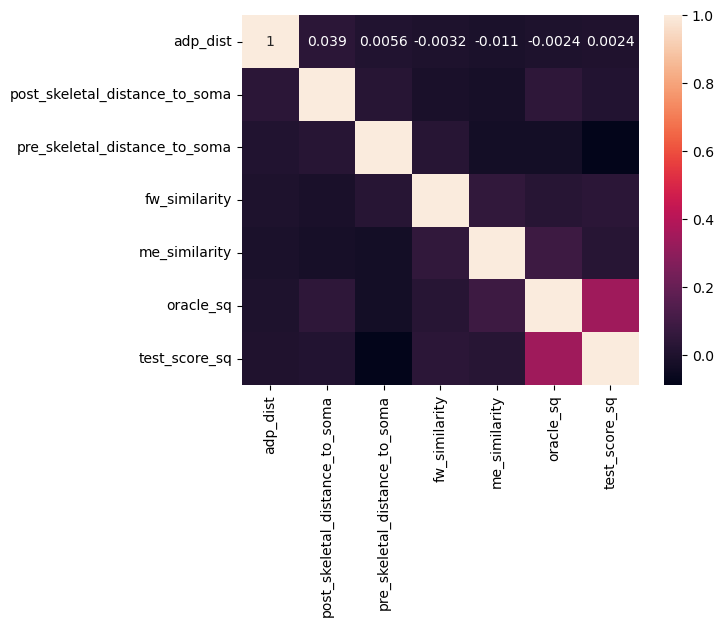

In [16]:
sns.heatmap(data[features].corr(), annot=True)
plt.show()

Either impute values or remove column 

In [33]:
# split data
#Get Training Set
X_train, X_temp, y_train, y_temp = train_test_split(data[features], data[target], test_size=0.3, random_state=42)

# Second, split the temporary set into validation and test sets
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Combine training and validation sets for tuned model training
X_train_combined = pd.concat([X_train, X_valid], axis=0)
y_train_combined = pd.concat([y_train, y_valid], axis=0)

In [34]:
def impute_missing(df, target_column,regressor, categorical_encoder):
   
    # Split the data into features and target
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # Identify missing values in the target column
    missing_mask = y.isnull()


    numerical_features_copy  = numerical_features.copy()
    numerical_features_copy.remove(target_column)
    # Define the column transformer for preprocessing
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', MinMaxScaler(), numerical_features_copy),  # Apply MinMaxScaler to numerical features
            ('cat', categorical_encoder, categorical_features)    # Apply OneHotEncoder to categorical features
        ])

    # Create the pipeline with RandomForestRegressor for imputation
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', regressor)
    ])

    # Fit the pipeline on the observed values
    pipeline.fit(X[~missing_mask], y[~missing_mask])

    # Predict missing values
    y_imputed = y.copy()
    y_imputed[missing_mask] = pipeline.predict(X[missing_mask])

    # Create a new DataFrame with imputed values
    df_imputed = df.copy()
    df_imputed[target_column] = y_imputed

    return df_imputed

In [70]:
#delete me_similarity column
X_train_nme = X_train.drop(columns=['me_similarity'], inplace = False)
X_valid_nme = X_valid.drop(columns=['me_similarity'], inplace = False)
X_test_nme = X_test.drop(columns=['me_similarity'], inplace = False)

In [35]:
#Linear regression imputation
X_train_lr = impute_missing(X_train, 'me_similarity', LinearRegression(), OneHotEncoder())
X_valid_lr = impute_missing(X_valid, 'me_similarity', LinearRegression(), OneHotEncoder())
X_test_lr = impute_missing(X_test, 'me_similarity', LinearRegression(),  OneHotEncoder())

X_train_combined_lr = impute_missing(X_train_combined, 'me_similarity', LinearRegression(), OneHotEncoder())

In [57]:
#RandomForest regression imputation 
X_train_rf = impute_missing(X_train, 'me_similarity', RandomForestRegressor(random_state=42, n_estimators= 100, max_depth= 5),TargetEncoder())
X_valid_rf = impute_missing(X_valid, 'me_similarity', RandomForestRegressor(random_state=42, n_estimators= 100, max_depth= 5),TargetEncoder())
X_test_rf = impute_missing(X_test, 'me_similarity', RandomForestRegressor(random_state=42, n_estimators= 100, max_depth= 5),TargetEncoder())

X_train_combined_rf = impute_missing(X_train_combined, 'me_similarity', RandomForestRegressor(random_state=42, n_estimators= 500, max_depth= 5),TargetEncoder())


In [64]:
#XGBoost regression imputation 
X_train_xg = impute_missing(X_train, 'me_similarity', XGBRegressor(random_state=42, n_estimators= 500, max_depth= 5),OneHotEncoder())
X_valid_xg = impute_missing(X_valid, 'me_similarity', XGBRegressor(random_state=42, n_estimators= 500, max_depth= 5),OneHotEncoder())
X_test_rf = impute_missing(X_test, 'me_similarity', XGBRegressor(random_state=42, n_estimators= 500, max_depth= 5),OneHotEncoder())

X_train_combined_xg = impute_missing(X_train_combined, 'me_similarity', XGBRegressor(random_state=42, n_estimators= 500, max_depth= 5),OneHotEncoder())


# LASSO for Feature Selection 

In [36]:
# Lasso with OneHotEncoding and me_similarity linear regression imputation


# Define the column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

X_pre = preprocessor.fit_transform(X_train_lr)

#Oversample
oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_pre, y_train)
   
# Define the pipeline with preprocessing, oversampling, and logistic regression
lasso = LogisticRegression(random_state=42, penalty='l1', solver='saga')


lasso.fit(X_train_resampled, y_train_resampled)
y_pred = lasso.predict_proba(preprocessor.transform(X_valid_lr))[:, 1]

print(round(balanced_accuracy_score(y_valid, y_pred > .5), 3))



0.762


In [48]:
X_train.drop(columns= ['me_similarity'], inplace = False)

,adp_dist,post_skeletal_distance_to_soma,pre_skeletal_distance_to_soma,fw_similarity,me_similarity,oracle_sq,test_score_sq,compartment,projection_group
120046,427.663,301372.0,546342.0,0.162111,0.863096,0.418861,0.390213,axon,V1_to_V1
92279,3816.740,94653.0,568076.0,0.094729,0.858570,0.754156,0.400105,basal,V1_to_V1
35604,2262.250,219743.0,1123220.0,0.112384,NaN,0.519083,0.312653,axon,RL_to_RL
54260,817.558,42498.7,599304.0,0.032665,NaN,0.705793,0.219730,basal,V1_to_V1
67956,4384.420,178971.0,1384330.0,0.175835,0.408579,0.673019,0.301903,basal,RL_to_RL
...,...,...,...,...,...,...,...,...,...
119879,597.300,141532.0,511353.0,0.196793,0.419443,0.493509,0.430525,oblique,V1_to_V1
103694,2393.020,104468.0,255770.0,0.112875,0.077078,0.552948,0.181346,axon,RL_to_V1
131932,4958.620,75883.3,714390.0,0.185309,0.946599,0.604832,0.221125,apical,V1_to_V1
146867,1300.230,80661.5,1065230.0,-0.008723,0.837130,0.576042,0.303679,basal,V1_to_V1


In [59]:
# Lasso with OneHotEncoding and me_similarity RandomForest Regression imputation


# Define the column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

X_pre = preprocessor.fit_transform(X_train_rf)

#Oversample
oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_pre, y_train)
   
# Define the pipeline with preprocessing, oversampling, and logistic regression
lasso = LogisticRegression(random_state=42, penalty='l1', solver='saga')


lasso.fit(X_train_resampled, y_train_resampled)
y_pred = lasso.predict_proba(preprocessor.transform(X_valid_rf))[:, 1]

print(round(balanced_accuracy_score(y_valid, y_pred > .5), 3))


0.762


In [65]:
# Lasso with OneHotEncoding and me_similarity XGBRegression imputation

# Define the column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

X_pre = preprocessor.fit_transform(X_train_xg)

#Oversample
oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_pre, y_train)
   
# Define the pipeline with preprocessing, oversampling, and logistic regression
lasso = LogisticRegression(random_state=42, penalty='l1', solver='saga')


lasso.fit(X_train_resampled, y_train_resampled)
y_pred = lasso.predict_proba(preprocessor.transform(X_valid_xg))[:, 1]

print(round(balanced_accuracy_score(y_valid, y_pred > .5), 3))

0.759


In [75]:
# Lasso with OneHotEncoding and no me_similarity

# Define the column transformer for preprocessing
numerical_features_nme = numerical_features.copy()
numerical_features_nme.remove('me_similarity')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features_nme),
        ('cat', OneHotEncoder(), categorical_features)
    ])



X_pre = preprocessor.fit_transform(X_train_nme)

#Oversample
oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_pre, y_train)
   
# Define the pipeline with preprocessing, oversampling, and logistic regression
lasso = LogisticRegression(random_state=42, penalty='l1', solver='saga')


lasso.fit(X_train_resampled, y_train_resampled)
y_pred = lasso.predict_proba(preprocessor.transform(X_valid_nme))[:, 1]

print(round(balanced_accuracy_score(y_valid, y_pred > .5), 3))


0.759


In [82]:
# Lasso with TargetEncoding and me_similarity linear regression imputation


# Define the column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),
        ('cat', TargetEncoder(), categorical_features)
    ])

X_pre = preprocessor.fit_transform(X_train_lr, y_train)

#Oversample
oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_pre, y_train)
   
# Define the pipeline with preprocessing, oversampling, and logistic regression
lasso = LogisticRegression(random_state=42, penalty='l1', solver='saga')


lasso.fit(X_train_resampled, y_train_resampled)
y_pred = lasso.predict_proba(preprocessor.transform(X_valid_lr))[:, 1]

print(round(balanced_accuracy_score(y_valid, y_pred > .5), 3))


0.752


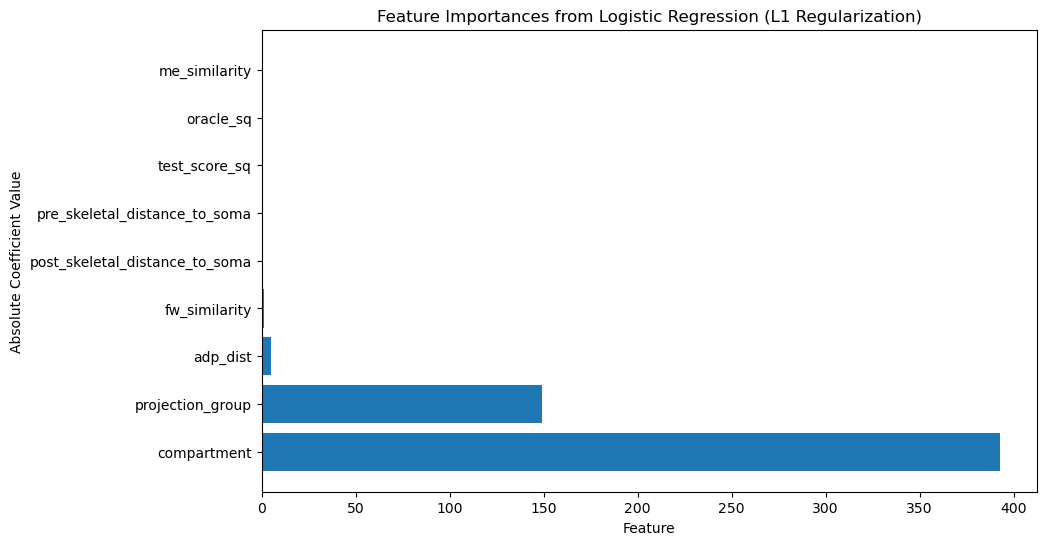

In [83]:
# Get feature importances (absolute values of coefficients for L1 regularization)
feature_importances = np.abs(lasso.coef_[0])

# Sort the features based on their importance
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(X_train.shape[1]), sorted_feature_importances, align="center")
plt.yticks(range(X_train.shape[1]), np.array(X_train.columns)[sorted_indices])
plt.xlabel("Feature")
plt.ylabel("Absolute Coefficient Value")
plt.title("Feature Importances from Logistic Regression (L1 Regularization)")
plt.show()

In [110]:
# Lasso with OneHotEncoding and me_similarity linear regression imputation


# Define the column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

X_pre = preprocessor.fit_transform(X_train_combined_lr)

#Oversample
oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_pre, y_train_combined)
   
# Define the pipeline with preprocessing, oversampling, and logistic regression
 
cv = StratifiedKFold(n_splits=5)
param_grid = {'C': np.logspace(-2,1,6),
              'l1_ratio': [0,0.25,0.5,0.75,1]}


grid = GridSearchCV(LogisticRegression(random_state=42, penalty= 'elasticnet', solver = 'saga'),
                     param_grid = param_grid, cv = cv , scoring = 'balanced_accuracy' )
grid.fit(X_train_resampled, y_train_resampled)

print(grid.best_params_)
print(grid.best_score_)

logistic = LogisticRegression(**grid.best_params_)


logistic.fit(X_train_resampled, y_train_resampled)
y_pred = logistic.predict_proba(preprocessor.transform(X_test_lr))[:, 1]

print(round(balanced_accuracy_score(y_test, y_pred > .5), 3))



In [ ]:
# Logistic with OneHotEncoding and me_similarity random forest imputation


# Define the column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

X_pre = preprocessor.fit_transform(X_train_combined_lr)

#Oversample
oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_pre, y_train_combined)

    
# Logistic Regression Params from Grid Search
lasso = LogisticRegression(random_state=42, penalty='elasticnet', solver='saga', C = 0.01, l1_ratio=0.5)


lasso.fit(X_train_resampled, y_train_resampled)
y_pred = lasso.predict_proba(preprocessor.transform(X_test_lr))[:, 1]

print(round(balanced_accuracy_score(y_test, y_pred > .5), 3))


In [ ]:
# Logistic with OneHotEncoding and me_similarity random forest imputation


# Define the column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

X_pre = preprocessor.fit_transform(X_train_combined_lr)

#Oversample
oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_pre, y_train_combined)

    
# Logistic Regression Params from Grid Search
lasso = LogisticRegression(random_state=42, penalty='elasticnet', solver='saga', C = 0.01, l1_ratio=0.5)


lasso.fit(X_train_resampled, y_train_resampled)
y_pred = lasso.predict_proba(preprocessor.transform(X_test_lr))[:, 1]

print(round(balanced_accuracy_score(y_test, y_pred > .5), 3))


0.795


In [ ]:
# Lasso with Target and me_similarity random forest imputation


# Define the column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),
        ('cat', TargetEncoder(), categorical_features)
    ])

X_pre = preprocessor.fit_transform(X_train_combined_rf, y_train_combined)

#Oversample
oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_pre, y_train_combined)

    
# Define the pipeline with preprocessing, oversampling, and logistic regression
lasso = LogisticRegression(random_state=42, penalty='l1', solver='saga')


lasso.fit(X_train_resampled, y_train_resampled)
y_pred = lasso.predict_proba(preprocessor.transform(X_test_rf))[:, 1]

print(round(balanced_accuracy_score(y_test, y_pred > .5), 3))

0.784


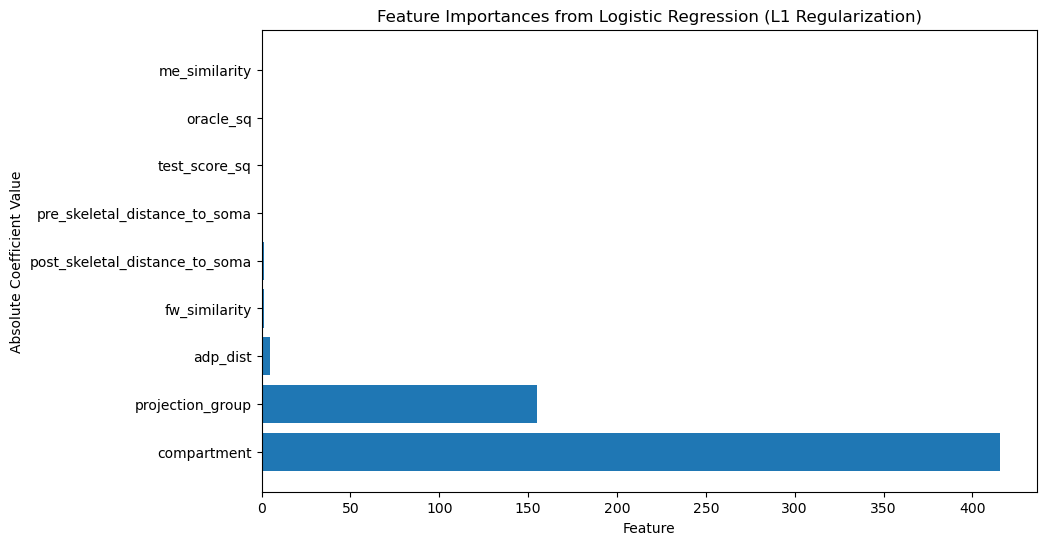

In [ ]:
# Get feature importances (absolute values of coefficients for L1 regularization)
feature_importances = np.abs(lasso.coef_[0])

# Sort the features based on their importance
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(X_train.shape[1]), sorted_feature_importances, align="center")
plt.yticks(range(X_train.shape[1]), np.array(X_train.columns)[sorted_indices])
plt.xlabel("Feature")
plt.ylabel("Absolute Coefficient Value")
plt.title("Feature Importances from Logistic Regression (L1 Regularization)")
plt.show()

# Random Forest for Feature Selection

In [ ]:
#   Random Forest with me_similarity imputation

In [ ]:
def plot_feature_importance(model, feature_names, title="Feature Importance", rotation=45):
  
    feature_importance = model.feature_importances_
    sorted_idx = np.argsort(feature_importance)

    plt.figure(figsize=(10, 6))
    plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align="center")
    plt.yticks(range(len(sorted_idx)), np.array(feature_names)[sorted_idx])
    plt.xlabel("Feature Importance")
    plt.title(title)
    plt.xticks(rotation=rotation)
    plt.show()

In [ ]:
# RandomForest with Target and me_similarity linear regression imputation

# Define the column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),
        ('cat', TargetEncoder(), categorical_features)
    ])

X_pre = preprocessor.fit_transform(X_train_lr, y_train)

oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_pre, y_train)


    
# Define the pipeline with preprocessing, oversampling, and logistic regression
model = RandomForestClassifier(random_state=42, n_estimators= 500, max_depth= 5)


model.fit(X_train_resampled, y_train_resampled)
y_pred = model.predict_proba(preprocessor.transform(X_valid_lr))[:, 1]

print(round(balanced_accuracy_score(y_test, y_pred > .5), 3))

0.488


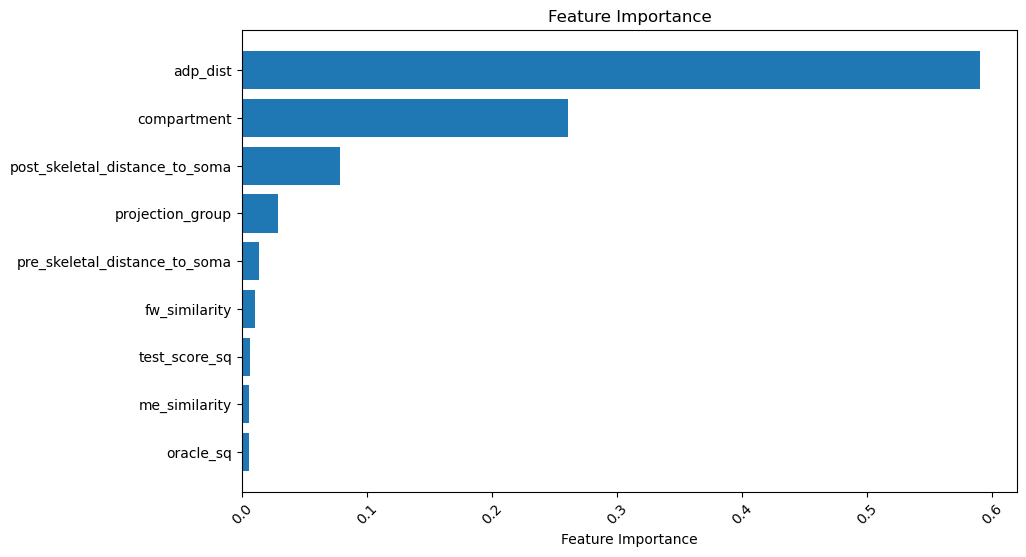

In [ ]:
plot_feature_importance(model, features, title="Feature Importance", rotation=45)

In [ ]:
# RandomForest with Target and me_similarity linear regression imputation

# Define the column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

X_pre = preprocessor.fit_transform(X_train_lr)

oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_pre, y_train)


model = RandomForestClassifier(random_state=42, n_estimators= 500, max_depth= 10)


model.fit(X_train_resampled, y_train_resampled)
y_pred = model.predict_proba(preprocessor.transform(X_test_lr))[:, 1]

print(round(balanced_accuracy_score(y_test, y_pred > .5), 3))

0.787


In [ ]:
#RandomForest without Encoding
# Define the column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),
    ])

X_pre = preprocessor.fit_transform(X_train_lr)

oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_pre, y_train)


    
# Define the pipeline with preprocessing, oversampling, and logistic regression
model = RandomForestClassifier(random_state=42, n_estimators= 500, max_depth= 10)


model.fit(X_train_resampled, y_train_resampled)
y_pred = model.predict_proba(preprocessor.transform(X_test_lr))[:, 1]

print(round(balanced_accuracy_score(y_test, y_pred > .5), 3))

0.72


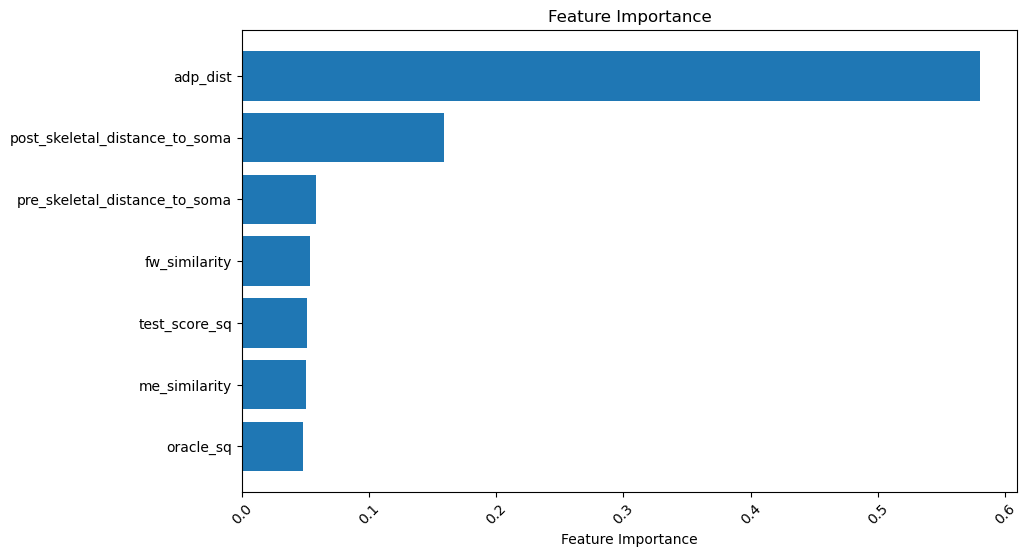

In [ ]:
plot_feature_importance(model, features, title="Feature Importance", rotation=45)

# Tuning Random Forest

In [ ]:
# Random Forest with OneHotEncoding and me_similarity linear regression imputation

# Define the column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

#combined data set as validation is done automatically
X_pre = preprocessor.fit_transform(X_train_combined_lr)

#Oversample
oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_pre, y_train_combined)
   
# Define the pipeline with preprocessing, oversampling, and logistic regression
 
cv = StratifiedKFold(n_splits=5)
param_grid = {'n_estimators': [100, 300, 500],
              'max_depth': [5,10,20,None],
              }


grid = GridSearchCV(RandomForestClassifier(n_jobs = -1),
                     param_grid = param_grid, cv = cv, scoring = 'balanced_accuracy' )
grid.fit(X_train_resampled, y_train_resampled)

print(grid.best_params_)
print(grid.best_score_)

rf = RandomForestClassifier(**grid.best_params_)


rf.fit(X_train_resampled, y_train_resampled)
y_pred = rf.predict_proba(preprocessor.transform(X_test_lr))[:, 1]

print(round(balanced_accuracy_score(y_test, y_pred > .5), 3))


TypeError: missing a required argument: 'y_true'

In [ ]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,8.554926,0.958021,0.002782,0.003091,5,100,"{'max_depth': 5, 'n_estimators': 100}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,21.400429,1.331374,0.000199,0.000398,5,300,"{'max_depth': 5, 'n_estimators': 300}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,34.766176,1.399026,0.001201,0.000400,5,500,"{'max_depth': 5, 'n_estimators': 500}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,12.198737,0.541112,0.000399,0.000489,10,100,"{'max_depth': 10, 'n_estimators': 100}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,33.589326,0.905618,0.000599,0.000489,10,300,"{'max_depth': 10, 'n_estimators': 300}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
5,56.678972,0.632955,0.000995,0.000632,10,500,"{'max_depth': 10, 'n_estimators': 500}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
6,15.978566,0.441716,0.000501,0.000447,20,100,"{'max_depth': 20, 'n_estimators': 100}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
7,45.001175,0.648867,0.000200,0.000399,20,300,"{'max_depth': 20, 'n_estimators': 300}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
8,74.584821,0.561593,0.000599,0.000489,20,500,"{'max_depth': 20, 'n_estimators': 500}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
9,17.026845,0.606606,0.000802,0.000749,None,100,"{'max_depth': None, 'n_estimators': 100}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


# Gradient Boosting 

In [ ]:
# Gradient Boosting with Target and me_similarity linear regression imputation

# Define the column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

X_pre = preprocessor.fit_transform(X_train_combined_lr, y_train_combined)

oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_pre, y_train_combined)


    
# Define the pipeline with preprocessing, oversampling, and logistic regression
model = GradientBoostingClassifier()


model.fit(X_train_resampled, y_train_resampled)
y_pred = model.predict_proba(preprocessor.transform(X_test_lr))[:, 1]

print(round(balanced_accuracy_score(y_test, y_pred > .5), 3))

0.768


# Gradient Boosting Hypertuning

In [ ]:

# Define the column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

X_pre = preprocessor.fit_transform(X_train_combined_rf, y_train_combined)

#Oversample
oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_pre, y_train_combined)

    
X_pre = preprocessor.fit_transform(X_train_combined_lr)

oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_pre, y_train_combined)


cv = StratifiedKFold(n_splits=5)
    
param_grid = {
    'n_estimators': [200, 300],
    'max_depth': [ 5, 10, None],
    'subsample': [0.5, 1],
    'learning_rate': [0.1, 1, 5]
}

model =  GradientBoostingClassifier(random_state=42)
grid = GridSearchCV(model, param_grid = param_grid, n_jobs= -1, scoring = balanced_accuracy_score, cv = cv)

grid.fit(X_train_resampled, y_train_resampled)

print(grid.best_estimator_)
print(grid.best_score_)

# Submission Builder

In [ ]:
#we need to first load and merge the leaderboard data to have the same format as the training set
lb_data = pd.read_csv("./leaderboard_data.csv")

In [ ]:
lb_data = (
    lb_data.merge(
        feature_weights.rename(columns=lambda x: "pre_" + x), 
        how="left", 
        validate="m:1",
        copy=False,
    )
    .merge(
        feature_weights.rename(columns=lambda x: "post_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
    .merge(
        morph_embeddings.rename(columns=lambda x: "pre_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
    .merge(
        morph_embeddings.rename(columns=lambda x: "post_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
)

In [ ]:
feature_engineering(lb_data)

In [ ]:
X_lb = impute_missing(lb_data[features], 'me_similarity', LinearRegression())

In [ ]:
#Use all Training Data
#X_train_final_lr = pd.concat([X_train_combined_lr, X_test_lr], axis=0)

In [ ]:
X_train_final_lr = X_train_combined_lr

In [ ]:
# fit preprocessor with training data and transform X_train, X_test
preprocessor.fit(X_train_final_lr)
X_final_transformed = preprocessor.transform(X_train_final_lr)

y_train = data[target]

X_test_transformed_lb = preprocessor.transform(X_lb)


## oversample connected neuron pairs for full training data
oversample = RandomOverSampler(random_state=42)

X_resampled, y_resampled = oversample.fit_resample(
    X_final_transformed, data[target]
)

#train model
#best_gboost = GradientBoostingClassifier(subsample=0.5)
model = LogisticRegression(random_state=42, penalty='l1', solver='saga')

#best_gboost.fit(X_resampled, y_resampled)
model.fit(X_resampled, y_resampled)

# predict on leaderboard data
lb_data["pred"] = model.predict_proba(X_test_transformed_lb)[:, 1]

#create a boolean prediction solution
lb_data["connected"] = lb_data["pred"] > .5

In [ ]:
#columns should be ID, connected
submission_data = lb_data.filter(['ID','connected'])

In [ ]:
import os
os.chdir(r"C:\Users\danie\OneDrive\Desktop\Fall2023\ELEC478\Competition")

In [ ]:
#writing csv files
submission_data.to_csv('submission_11.csv',index=False)